# House Sales in King County, USA - TensorFlow Regression - Kaggle

## Reading in the data

I will be making use of the data found in the following Kaggle dataset: https://www.kaggle.com/harlfoxem/housesalesprediction

Importing the libraries that I will be making use of:

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Since I am using Jupyter Notebook and I would like to see plots displayed directly below the code cells that produce them, I must use the following:

In [39]:
%matplotlib inline

<br>

In [40]:
df = pd.read_csv('kc_house_data.csv')

The data contains information on over 21,000 houses sold in the King County area between May 2014 and May 2015. I will split this data into a training set and a test set. The training set will be used to train a neural network and the test set will be used to test this neural network. I will be predicting a price for each house in the test set and comparing it to the actual value in order to evaluate my model.

In [41]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Descriptions for the columns can be seen below:

## Feature Columns

id - Unique ID for each home sold

date - Date of the home sale

price - Price of each home sold

bedrooms - Number of bedrooms

bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower

sqft_living - Square footage of the apartments interior living space

sqft_lot - Square footage of the land space

floors - Number of floors

waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not

view - An index from 0 to 4 of how good the view of the property was

condition - An index from 1 to 5 on the condition of the apartment,

grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an 
average level of construction and design, and 11-13 have a high quality level of construction and design.

sqft_above - The square footage of the interior housing space that is above ground level

sqft_basement - The square footage of the interior housing space that is below ground level

yr_built - The year the house was initially built

yr_renovated - The year of the house’s last renovation

zipcode - What zipcode area the house is in

lat - Lattitude

long - Longitude

sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

## Data visualisation

### This section is just to explore the data and gain some preliminary insight. You can skip to the feature engineering section if you don't want to view this.


In [42]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

There appear to be no null values which means we won't have to do any cleaning. We will do some feature engineering later on.

Let's look at the correlation between the 'price' column and other columns:

In [43]:
df.corr()['price'].sort_values()

zipcode         -0.053402
id              -0.016772
long             0.022036
condition        0.036056
yr_built         0.053953
sqft_lot15       0.082845
sqft_lot         0.089876
yr_renovated     0.126424
floors           0.256804
waterfront       0.266398
lat              0.306692
bedrooms         0.308787
sqft_basement    0.323799
view             0.397370
bathrooms        0.525906
sqft_living15    0.585241
sqft_above       0.605368
grade            0.667951
sqft_living      0.701917
price            1.000000
Name: price, dtype: float64

As you would expect, square footage of the house, grade and number of bathrooms and bedroom have some correlation with the price of the house.

C:\Users\Pritesh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bedrooms', ylabel='count'>

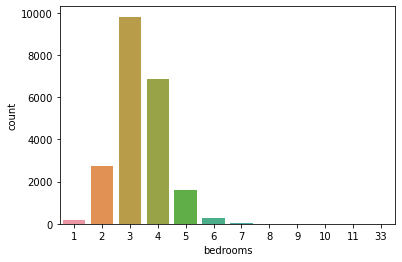

In [44]:
sns.countplot(df['bedrooms'])

<AxesSubplot:xlabel='price', ylabel='sqft_living'>

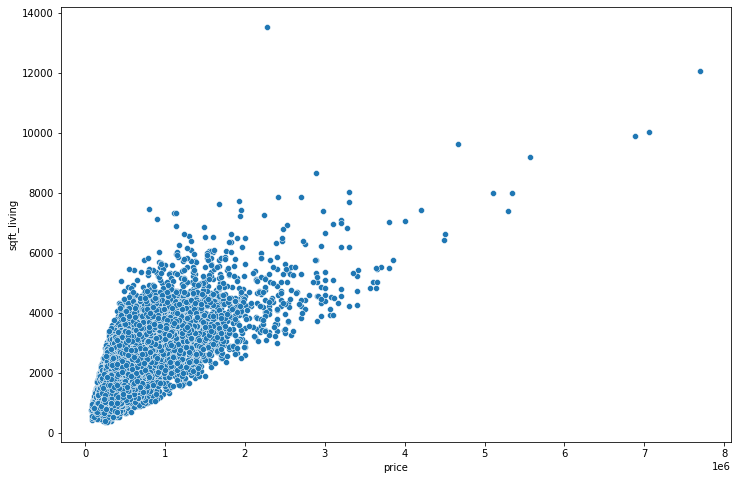

In [45]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='price',y='sqft_living',data=df)

The above figure shows a very strong linear relationship between sqft_living and price.

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

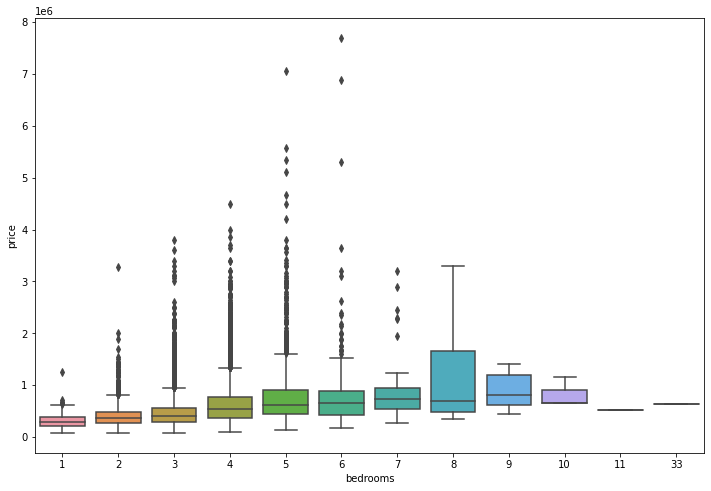

In [46]:
plt.figure(figsize=(12,8))
sns.boxplot(x='bedrooms',y='price',data=df)

The above plot shows the distribution of prices of houses per number of bedrooms. We know from earlier that most of the houses have between 3 and 7 bedrooms so it makes sense that the prices have a large variety for these.

Let's take a look at the distribution of house prices.

<AxesSubplot:xlabel='price', ylabel='Count'>

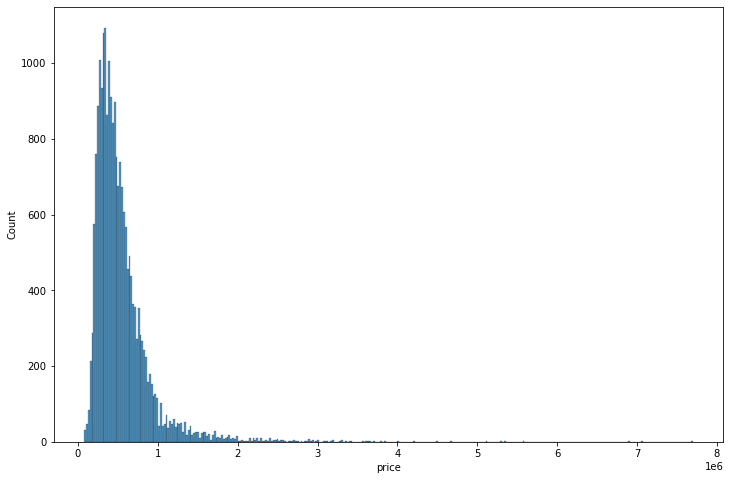

In [47]:
plt.figure(figsize=(12,8))
sns.histplot(df['price'])

Most of the houses fall between \\$0 and \\$1.5million. There do appear to be some (albeit very few) houses that are priced higher than $4 million.

<AxesSubplot:xlabel='waterfront', ylabel='price'>

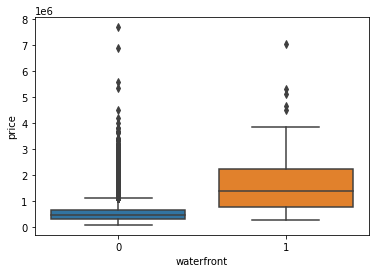

In [48]:
sns.boxplot(x='waterfront',y='price',data=df)

Houses on the waterfront are more likely to be more expensive than those that aren't.

## Feature engineering

In [49]:
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

I will drop the 'id' column as it does not have any useful information that we can use for our model.

In [50]:
df = df.drop('id',axis=1)

### Feature engineering using the date column

In its current format, the data column is not usable. I can however grab the month and year for each data point and use this in my model. 

First, converting the date column to the Pandas datetime format.

In [51]:
df['date'] = pd.to_datetime(df['date'])

Next, grabbing the month and the year from each date and putting them into new columns called 'month' and 'year' respectively. I will use a simple lambda function combined with the apply method.

In [52]:
df['month'] = df['date'].apply(lambda x:x.month)

In [53]:
df['year'] = df['date'].apply(lambda x:x.year)

Now I can drop the original date column as we won't be able to use this.

In [54]:
df = df.drop('date',axis=1)

I will also drop the zipcode column as this is technically a categorical column.

In [56]:
df = df.drop('zipcode',axis=1)

In [57]:
df.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  538000.0         3       2.25         2570      7242     2.0           0   
2  180000.0         2       1.00          770     10000     1.0           0   
3  604000.0         4       3.00         1960      5000     1.0           0   
4  510000.0         3       2.00         1680      8080     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      7        2170            400      1951          1991   
2     0          3      6         770              0      1933             0   
3     0          5      7        1050            910      1965             0   
4     0          3      8        1680              0      1987             0   

       lat     long  sqft_living15  sqft_lot15  month  year  
0  47.5112 -122.257           1340        5650     10  2014  
1  47.7210 -122.319           1690        7639     12  2014  
2  47.7379 -122.233           2720        8062      2  2015  
3  47.5208 -122.393           1360        5000     12  2014  
4  47.6168 -122.045           1800        7503      2  2015

Looking at the two columns 'yr_renovated' and 'sqft_basement', it appears that if the houses have not been renovated, or they do not have basements, the value for these is set to 0:

In [58]:
df['yr_renovated'].value_counts()

0       20683
2014       91
2013       37
2003       36
2000       35
        ...  
1934        1
1959        1
1951        1
1948        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

In [59]:
df['sqft_basement'].value_counts()

0       13110
600       221
700       218
500       214
800       206
        ...  
792         1
2590        1
935         1
2390        1
248         1
Name: sqft_basement, Length: 306, dtype: int64

We could feature engineer these columns so that if the houses were renovated or had a basement, they would have a value of 1 in those columns, and 0 otherwise. However, we don't have to do this because of the following:

For year renovated, houses that were renovated more recently would correlate with a higher price and so we can leave this column as it is.

Similar to square footage of basement, a larger basement would correlate with a higher price.

We can leave these two variables as continuous in this case.